<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://raw.githubusercontent.com/Unidata/MetPy/master/metpy/plots/_static/unidata_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

<h1>Making a Simple RGB Satellite Composite</h1>
<h3>Unidata Python Workshop</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

<div style="float:right; width:250 px"><img src="https://unidata.github.io/MetPy/latest/_images/sphx_glr_GINI_Water_Vapor_001.png" alt="Example Satellite Image" style="height: 500px;"></div>


## Overview:

* **Teaching:** 10 minutes
* **Exercises:** None

### Questions
1. How can array manipulation be used with imagery data?
2. How can multiple channels of data be combined into an RGB image?
3. How can complex functionality be broken up into smaller reuseable and encapsulated functions?

### Objectives
1. Download satellite data with Siphon
2. Parse out netCDF file
3. Create an RGB composite

Color images consist of red, green, and blue components. We can assign any channel we wish to any color to make false-color images that help locate features of interest such as smoke, deep moisture, etc. In this notebook we'll make a simple image showing lower, mid, and upper level water vapor. Note that not all channels from the GOES-16 satellite are on the same grid or are the same size. This is also changing as the satellite is still experimental, so not any arbitrary channel combination will work without resampling (as shown in the GOES_RGB_Image notebook).

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib.pyplot as plt
from matplotlib import patheffects
from metpy.plots import add_metpy_logo
import numpy as np
from siphon.catalog import TDSCatalog

%matplotlib inline

In [2]:
def open_dataset(date, channel, region, idx):
    """
    Open and return a netCDF Dataset object for a given date, channel, and image index
    of GOES-16 data from THREDDS test server.
    """
    cat = TDSCatalog('http://thredds-test.unidata.ucar.edu/thredds/catalog/satellite/goes16/GOES16/'
                 '{}/Channel{:02d}/{:%Y%m%d}/catalog.xml'.format(region, channel, date))
    ds = cat.datasets[idx]
    return ds.remote_access(service='OPENDAP')
    
def make_RGB_data(date, region, idx):
    """
    Make an RGB image array, returning the time, coordinates, projection, and data.
    """
    red_channel = 10
    green_channel = 9
    blue_channel = 8
                         
    red_ds = open_dataset(date, red_channel, region, idx)
    blue_ds = open_dataset(date, blue_channel, region, idx)
    green_ds = open_dataset(date, green_channel, region, idx)
    
    # Pull out data and apply sqrt brightness enhancement
    green_data = np.sqrt(green_ds.variables['Sectorized_CMI'][:])
    blue_data = np.sqrt(blue_ds.variables['Sectorized_CMI'][:])
    red_data = np.sqrt(red_ds.variables['Sectorized_CMI'][:])

    rgb_data = np.dstack([red_data, green_data, blue_data])

    x = red_ds.variables['x'][:]
    y = red_ds.variables['y'][:]  
    proj_var = red_ds.variables[green_ds.variables['Sectorized_CMI'].grid_mapping]

    time = datetime.strptime(green_ds.start_date_time, '%Y%j%H%M%S')
    
    return time, x, y, proj_var, rgb_data

In [3]:
# Get the most recent image and make the RGB data array.
date = datetime.utcnow()
timestamp, x, y, proj_var, rgb_data = make_RGB_data(date, 'Mesoscale-1', -2)

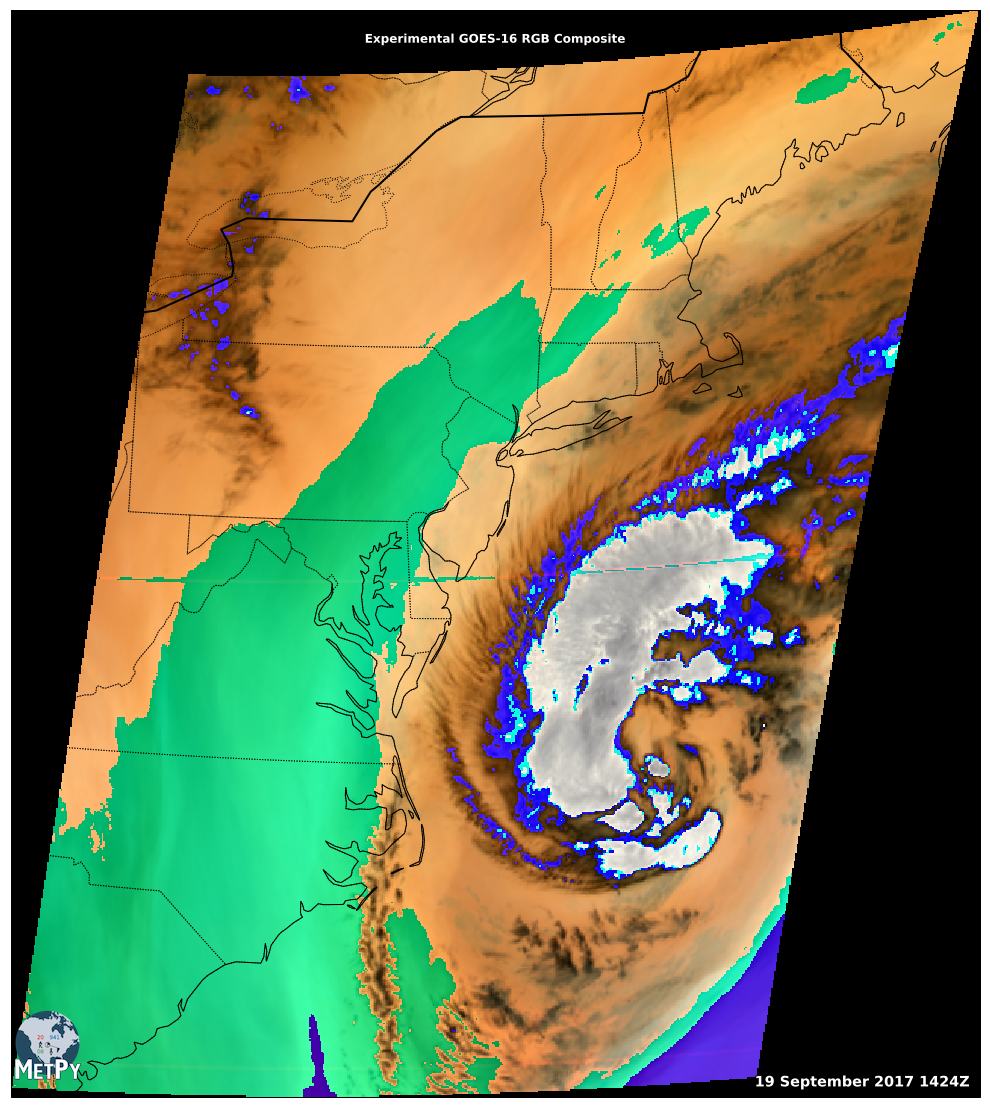

In [4]:
# Create a Globe specifying a spherical earth with the correct radius
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=proj_var.semi_major,
                   semiminor_axis=proj_var.semi_minor)

# Select the correct projection.

proj = ccrs.LambertConformal(central_longitude=proj_var.longitude_of_central_meridian,
                             central_latitude=proj_var.latitude_of_projection_origin,
                             standard_parallels=[proj_var.standard_parallel],
                             globe=globe)

#proj = ccrs.Mercator(central_longitude=proj_var.longitude_of_projection_origin, 
#                     latitude_true_scale=proj_var.standard_parallel,
#                     globe=globe)

# Set up a feature for the state/province lines. Tell cartopy not to fill in the polygons
state_boundaries = cfeat.NaturalEarthFeature(category='cultural',
                                             name='admin_1_states_provinces_lakes',
                                             scale='50m', facecolor='none')

# Same as before, except we call imshow with our colormap and norm.
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=proj)

im = ax.imshow(rgb_data, extent=(x.min(), x.max(), y.min(), y.max()), origin='upper')
ax.coastlines(resolution='50m', color='black')
ax.add_feature(state_boundaries, linestyle=':', edgecolor='black')
ax.add_feature(cfeat.BORDERS, linewidth='2', edgecolor='black')

# Add text (aligned to the right); save the returned object so we can manipulate it.
text_time = ax.text(0.99, 0.01, timestamp.strftime('%d %B %Y %H%MZ'),
               horizontalalignment='right', transform=ax.transAxes,
               color='white', fontsize='x-large', weight='bold')

text_channel = ax.text(0.5, 0.97, 'Experimental GOES-16 RGB Composite',
               horizontalalignment='center', transform=ax.transAxes,
               color='white', fontsize='large', weight='bold')

# Make the text stand out even better using matplotlib's path effects
outline_effect = [patheffects.withStroke(linewidth=2, foreground='black')]
text_time.set_path_effects(outline_effect)
text_channel.set_path_effects(outline_effect)

# Add the MetPy Logo
fig = add_metpy_logo(fig)